In [1]:
from matplotlib import pyplot as plt
import numpy as np
from dune.grid import cartesianDomain
from dune.grid import yaspGrid
from dune.alugrid import aluConformGrid
#from dune.grid import reader
#from dune. import gmsh2DGF
from dune.fem.utility import gridWidth
import pygmsh

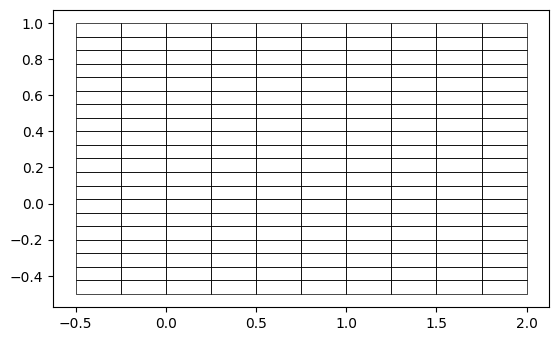

In [2]:
# Task 5
domain = cartesianDomain([-.5, -.5], [2, 1], [10, 20])
gridView = yaspGrid(domain)
gridView.plot()

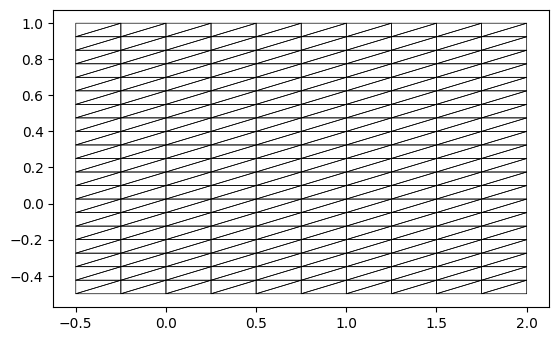

In [3]:
# Task 6
aluView = aluConformGrid(domain)
aluView.plot()

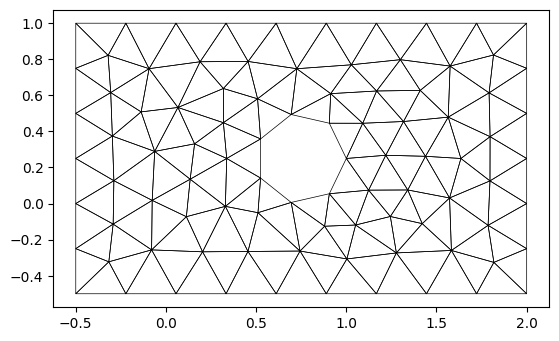

In [9]:
# Task 8
with pygmsh.occ.Geometry() as geom:
    L = 2.5
    H = 1.5
    x_hole = (-0.5+L/2)
    y_hole = (-0.5+H/2)
    radius = 0.25
    rectangle = geom.add_rectangle([-.5, -.5, 0], L, H)
    disk = geom.add_ball([x_hole, y_hole, 0], radius)
    geom.boolean_difference(rectangle, disk)
    mesh = geom.generate_mesh(dim=2)
# Generate domain
points, cells = np.array([np.array([x, y]) for x, y, z in mesh.points]), mesh.cells_dict
#print(type(points), points[0])
#print(cells.keys())
domain = {"vertices":points.astype("float"), "simplices":cells["triangle"]}
# Generate grid
holeGridView = aluConformGrid(domain, dimgrid=2)
holeGridView.plot()

In [3]:
# Task 9
def ourGridWidth(gridView):
    # Iterate through elements in gridView, computing
    # max distance between corners of each
    # The gridWidth of the grid is the largest such distance
    D_max = 0
    # codim of zero -> triangles (top level elements)
    for entity in gridView.entities(codim=0):
        # Get distance between corners, check if any larger than current max
        corners = np.array(entity.geometry.corners)
        for i in range(len(corners)):
            for j in range(i+1, len(corners)):
                D = np.sqrt(np.sum((corners[i]-corners[j])**2))
                if D > D_max:
                    D_max = D
                    #print(f"Found new max: {D_max}")
    return D_max

# Grid width our version
ourWidth = ourGridWidth(holeGridView)
duneWidth = gridWidth(holeGridView)
print(f"Our final grid width: {ourWidth:.5f}")
print(f"Dune grid width: {duneWidth:.5f}")

Our final grid width: 0.31554
Dune grid width: 0.04241


In [4]:
# Task 10
from dune.fem.function import gridFunction
from dune.common import FieldVector

# Piece-wise constant grid function that measures the grid width on each element
@gridFunction(holeGridView, name="GridWidth", order=3)
def gridWidthFunction(element, _): # Second parameter for compatibility with the f(e, x) signature expected by dune
    D_max = 0
    corners = np.array(element.geometry.corners)
    for i in range(len(corners)):
        for j in range(i+1, len(corners)):
            D = np.sqrt(np.sum((corners[i]-corners[j])**2))
            if D > D_max:
                D_max = D
    return D_max

# Get max value using the grid function
maxValue = np.max([gridWidthFunction(e, 0) for e in gridWidthFunction.gridView.elements]) # Again, call with second dummy argument to avoid global lookup (hangs program)
print(f"Max width of an element: {maxValue:.5f}")

Max width of an element: 0.31554


In [5]:
# Task 11
# Create a DoF mapper which assigns one DoF to each vertex (dim=0) in the grid
mapper = holeGridView.mapper(lambda gt: 1 if gt.dim==0 else 0)
# Print the degrees of freedom
print(f"This map has {mapper.size} degrees of freedom")
# Print number of vertices
print(f"There are {len([v for v in holeGridView.vertices])} vertices in the grid")

This map has 92 degrees of freedom
There are 92 vertices in the grid


In [6]:
v0 = [v for v in holeGridView.vertices][0]
print(v0.geometry.center)

(-0.500000, -0.500000)


In [19]:
e0 = [e for e in holeGridView.elements][0]
data = np.zeros(mapper.size)
print(e0.vertices)
print([mapper.index(v) for v in e0.vertices])
print(mapper.subIndices(e0, holeGridView.dimension))
print(data[np.array(mapper.subIndices(e0, holeGridView.dimension))])

(<dune.generated.hierarchicalgrid_d827e80243feae36e8b9006bb24207e7.LeafGrid.Entity_2 object at 0x71c7ec810570>, <dune.generated.hierarchicalgrid_d827e80243feae36e8b9006bb24207e7.LeafGrid.Entity_2 object at 0x71c7ec813df0>, <dune.generated.hierarchicalgrid_d827e80243feae36e8b9006bb24207e7.LeafGrid.Entity_2 object at 0x71c7ec810a30>)
[0, 1, 2]
(0, 1, 2)
[0. 0. 0.]


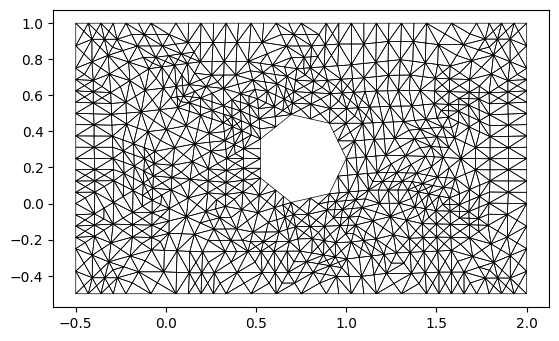

In [10]:
# Refine the grid three times globally
holeGridView.hierarchicalGrid.globalRefine(3)
holeGridView.plot()

-0.4769510074186103
-0.4403105926486066
-0.41696413336694177
-0.40750656297416576
-0.38534997049360126


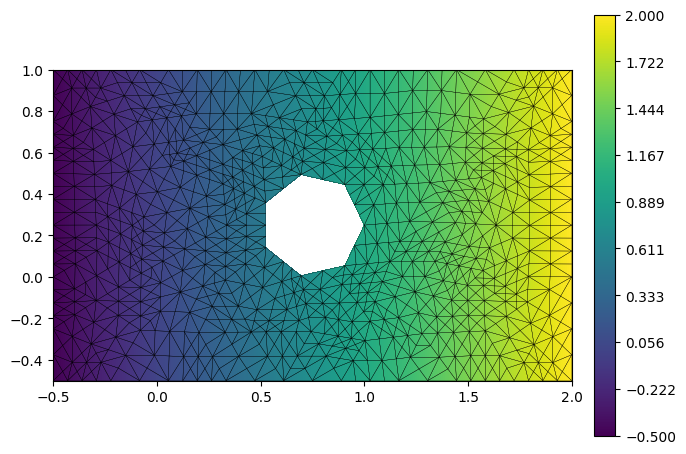

In [12]:
# Task 12
# Part 1: Create a function linearInterpolation that takes a grid function u and a gridView
# It should return a mapper and vector of DoF values from u on the vertices
def linearInterpolation(u, gridView):
    # Create a mapper
    mapper = u.gridView.mapper(lambda gt: 1 if gt.dim==0 else 0) # 1 DoF per vertex
    # Vector for values
    dof_vec = np.zeros(mapper.size)
    # Iterate through the vertices, applying u at each one
    for vertex in u.gridView.vertices:
        idx = mapper.index(vertex)
        dof_vec[idx] = u(vertex.geometry.center)
    return mapper, dof_vec

# Part 2: Create a grid function uh that linearly interpolates given the mapper and dof vector
# In this case, we first create a callable class so we can attach state variables containing the mapper,
# dof_vec, and grid view
class LinearInterpolator():
    def __init__(self, mapper, dof_vec, gridView):
        self.mapper = mapper
        self.data = dof_vec
        self.gridView = gridView
    def __call__(self, element, x):
        # The actual grid function
        # Compute u(p0)(1-x0-x1) + u(p1)x0 + u(p2)x1
        # Indices of vertices in the DoF vector
        indices = np.array(self.mapper.subIndices(element, self.gridView.dimension))
        u_arr = self.data[indices] # u(p0), u(p1), u(p2)
        x_arr = np.array([1-x[0]-x[1], x[0], x[1]])
        #print(f"data for vertices: {u_arr}, interpolation coeffs: {x_arr}, original pt input: {x}")
        return np.dot(u_arr, x_arr)

@gridFunction(holeGridView, name='x', order=1)
def linear_x(x):
    return x[0]

# Get the mapper and DoF vector using some function
# In this case, testing with a linear function
mapper, data = linearInterpolation(linear_x, holeGridView)

# Define the callable class as a grid function using this mapper and data
uh = gridFunction(holeGridView, name='Interpolation of x', order=1)(LinearInterpolator(mapper, data, holeGridView))

point = FieldVector([0.2, 0.2])
for i, e in enumerate(uh.gridView.elements):
    #print(e.geometry.center)
    #print([v.geometry.center for v in e.vertices])
    #print([data[mapper.index(v)] for v in e.vertices])
    print(uh(e, point))
    if i == 4:
        break
#linear_x.plot()
uh.plot()